In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ptbdb_normal.csv to ptbdb_normal.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ptbdb_abnormal.csv to ptbdb_abnormal.csv


В третьей части ноутбука проводилась **оценка работы модели автоэнкодера** на различных данных. Вот основные шаги, которые были выполнены:

1. **Предсказания модели:**
   - Модель автоэнкодера использует обученные веса для того, чтобы предсказать значения для нормальных данных (обучающая и тестовая выборки) и аномальных данных.
   - Для каждого примера вычисляется ошибка (MAE, средняя абсолютная ошибка), которая показывает, насколько предсказанные значения отличаются от реальных.

2. **Установка порога для аномальных данных:**
   - В ходе обучения был выбран **порог**, который отделяет нормальные данные от аномальных.
   - Данные, у которых ошибка больше этого порога, считаются аномальными, а остальные — нормальными.

3. **Подготовка меток для классификации:**
   - Создаются два массива меток:
     - **`ytrue`** — реальные метки (нормальные данные получают метку 1, а аномальные — 0).
     - **`ypred`** — предсказания модели (также 1 для нормальных данных, если ошибка меньше порога, и 0 для аномальных данных).

4. **Матрица ошибок:**
   - Строится **матрица ошибок** (confusion matrix), которая показывает, сколько раз модель правильно или неправильно классифицировала нормальные и аномальные данные.
   - Также строится нормированная матрица ошибок, где для каждого значения показывается процент правильных и неправильных классификаций.

5. **Метрики качества модели:**
   - Вычисляются различные **метрики** для оценки качества модели:
     - **Точность (accuracy)** — как часто модель правильно классифицирует данные.
     - **Точность классификации (precision)** — сколько из предсказанных аномальных данных действительно являются аномальными.
     - **Полнота (recall)** — сколько из реально аномальных данных модель правильно классифицировала.
     - **F1-меры (f1-score)** — гармоническое среднее между точностью и полнотой, показывающее сбалансированную оценку работы модели.

6. **Отчёт:**
   - Генерируется **отчёт**, в котором показаны все важные метрики модели (точность, точность классификации, полнота и F1-score) и выводится сама матрица ошибок.

7. **Вывод отчёта по меткам:**
   - Выводится **классификационный отчёт**, который помогает понять, как хорошо модель справляется с задачей различения нормальных и аномальных данных.

Таким образом, эта часть ноутбука занимается **оценкой эффективности модели** для классификации данных как нормальных или аномальных, используя метрики точности и матрицу ошибок.

# Введение

Рассмотрим исследование в области обработки и классификации сигналов электрокардиограммы (ЭКГ), используя возможности автокодировщика сверточной нейронной сети (CNN). Выбрана диагностическая база данных PTB Diagnostic ECG Database. Основная цель — построить надежную модель автоэнкодера, адаптированную для задачи обнаружения аномальных сигналов электрокардиограммы (ЭКГ).

# Обзор набора данных

PTB Diagnostic ECG Database представляет собой набор из 14 552 записей ЭКГ, полученных из диагностической базы данных PTB компании Physionet. Эти сигналы ЭКГ подразделяются на два класса: нормальные сердечные сокращения и нарушения сердечной деятельности. Набор данных отбирается с частотой 125 Гц, что обеспечивает данные высокого разрешения для глубокого анализа.

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os

Этот код проверяет наличие доступных графических процессоров (GPU) для использования в TensorFlow. Функция tf.config.list_physical_devices('GPU') возвращает список всех доступных физических устройств, которые могут быть использованы для ускорения вычислений, таких как обучение нейронных сетей. Если на машине есть доступный GPU, он будет отображен в списке.

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[]

In [ ]:
normal_df = pd.read_csv("ptbdb_normal.csv").iloc[:, :-1]
anomaly_df = pd.read_csv("ptbdb_abnormal.csv").iloc[:, :-1]
normal_df.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Форма нормальных данных", normal_df.shape)
print("Форма аномальных данных", anomaly_df.shape)

Форма нормальных данных (4045, 187)
Форма аномальных данных (10505, 187)


Приведенный ниже код генерирует визуальное сравнение двух случайно выбранных образцов сигнала ЭКГ: одного из набора данных «Нормальный», а другого — из набора данных «Аномалия». Этот параллельный график позволяет провести прямую визуальную оценку структуры сигналов ЭКГ в нормальных и аномальных случаях.

In [ ]:
def plot_sample(normal, anomaly):
    index = np.random.randint(0, len(normal_df), 2)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax[0].plot(normal.iloc[index[0], :].values, label=f"Случай {index[0]}")
    ax[0].plot(normal.iloc[index[1], :].values, label=f"Случай {index[1]}")
    ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[0].set_title("Нормальный")

    ax[1].plot(anomaly.iloc[index[0], :].values, label=f"Случай {index[0]}")
    ax[1].plot(anomaly.iloc[index[1], :].values, label=f"Случай {index[1]}")
    ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[1].set_title("Аномальный")

    plt.tight_layout()
    plt.show()

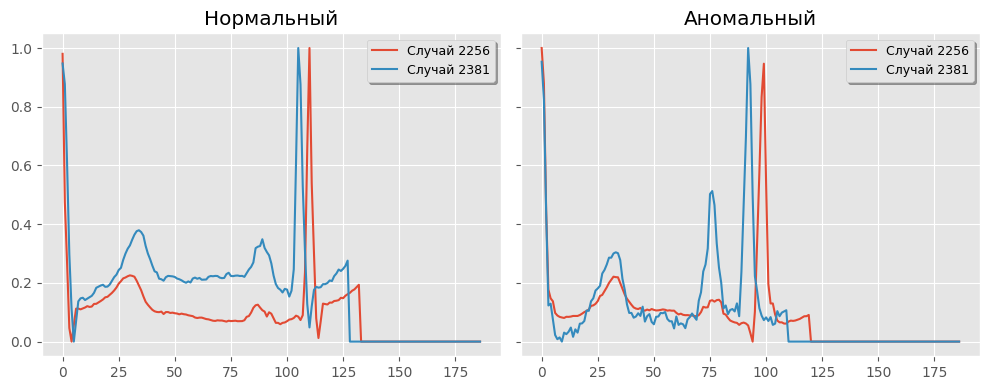

In [ ]:
plot_sample(normal_df, anomaly_df)

Этот код подготовит данные, чтобы они были в одном датафрейме, с добавленным столбцом, который указывает, к какому классу относится каждый пример.

In [ ]:
CLASS_NAMES = ["Нормальный", "Аномальный"]

normal_df_copy = normal_df.copy()
anomaly_df_copy = anomaly_df.copy()
print(anomaly_df_copy.columns.equals(normal_df_copy.columns))

False


In [ ]:
normal_df_copy = normal_df_copy.set_axis(range(1, 188), axis=1)
anomaly_df_copy = anomaly_df_copy.set_axis(range(1, 188), axis=1)
normal_df_copy = normal_df_copy.assign(target = CLASS_NAMES[0])
anomaly_df_copy = anomaly_df_copy.assign(target = CLASS_NAMES[1])


df = pd.concat((normal_df_copy, anomaly_df_copy))

# Сглаженный график среднего значения для сравнения классов

В этом коде определена функция под названием plot_smoothed_mean для создания Сглаженных графиков среднего значения для сравнения классов. В качестве параметров он принимает входные данные, имя класса и размер шага. Функция вычисляет скользящее среднее и стандартное отклонение данных с указанным размером шага, затем отображает сглаженное среднее значение вместе с заштрихованной областью, представляющей границу, в три раза превышающую стандартное отклонение.

Код также демонстрирует использование этой функции для сравнения сглаженных средних значений разных классов. Он создает подсюжет с двумя панелями, каждая из которых представляет отдельный класс. Данные для каждого класса группируются, и среднее значение вычисляется перед передачей его в функцию plot_smoothed_mean. Это позволяет визуализировать сравнение сглаженных средних значений разных классов.

Полученный график дает представление о том, как средние значения разных классов изменяются со временем или по какой-либо другой переменной, представленной данными, при этом заштрихованные области указывают на неопределенность вокруг средних оценок.

Эта функция plot_smoothed_mean строит усреднённый и сглаженный график сигналов с доверительным интервалом.

In [ ]:
def plot_smoothed_mean(data, class_name = "нормальный", step_size=5, ax=None):
    df = pd.DataFrame(data)
    roll_df = df.rolling(step_size)
    smoothed_mean = roll_df.mean().dropna().reset_index(drop=True)
    smoothed_std = roll_df.std().dropna().reset_index(drop=True)
    margin = 3*smoothed_std
    lower_bound = (smoothed_mean - margin).values.flatten()
    upper_bound = (smoothed_mean + margin).values.flatten()

    ax.plot(smoothed_mean.index, smoothed_mean)
    ax.fill_between(smoothed_mean.index, lower_bound, y2=upper_bound, alpha=0.3, color="red")
    ax.set_title(class_name, fontsize=9)

Этот код строит сравнительный график сглаженного среднего сигнала для двух классов — "Нормальный" и "Аномальный"

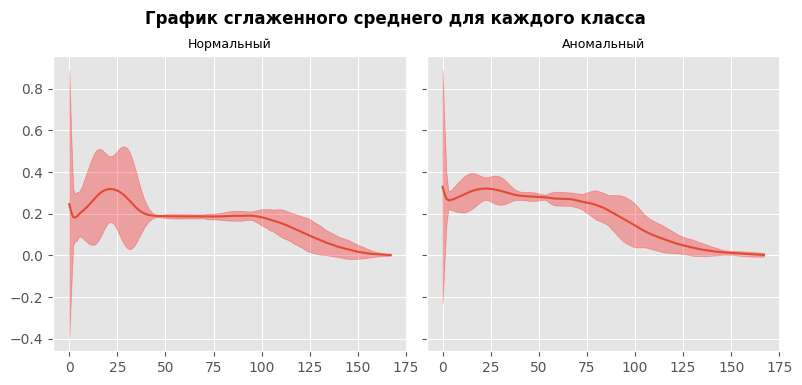

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten()
for i, label in enumerate(CLASS_NAMES, start=1):
    data_group = df.groupby("target")
    data = data_group.get_group(label).mean(axis=0, numeric_only=True).to_numpy()
    plot_smoothed_mean(data, class_name=label, step_size=20, ax=axes[i-1])
fig.suptitle("График сглаженного среднего для каждого класса", y=0.95, weight="bold")
plt.tight_layout()

# Разделение данных на обучающий и тестовый наборы

In [ ]:
normal_df.drop("target", axis=1, errors="ignore", inplace=True)
normal = normal_df.to_numpy()
anomaly_df.drop("target", axis=1, errors="ignore", inplace=True)
anomaly = anomaly_df.to_numpy()

X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)
print(f"Обучающий пример: {X_train.shape}, Тестовый пример: {X_test.shape}, Аномальный пример: {anomaly.shape}")

Обучающий пример: (3438, 187), Тестовый пример: (607, 187), Аномальный пример: (10505, 187)


# Построение модели автоэнкодера CNN

Об автоэнкодерах: изучение эффективных представлений данных
Автоэнкодеры — это класс архитектур нейронных сетей, обычно используемых в задачах машинного обучения без учителя и глубокого обучения. Их основная цель — обнаружить и изучить эффективные представления данных путем их кодирования в скрытое пространство меньшей размерности и последующего декодирования обратно в исходную форму. Автоэнкодеры играют решающую роль в различных приложениях, таких как уменьшение размерности, шумоподавление данных, обнаружение аномалий и генеративное моделирование.

Основные компоненты автокодировщика состоят из кодера и декодера. Кодер отображает входные данные в скрытое пространство, а декодер восстанавливает данные из их закодированного представления. Во время обучения автоэнкодеры стремятся минимизировать ошибку восстановления между входными и декодированными выходными данными, что приводит к обучению значимых представлений данных.

Автоэнкодеры предлагают универсальный инструмент для извлечения признаков, сжатия данных и многого другого, что делает их ценным дополнением к набору инструментов специалистов по обработке данных и практиков машинного обучения.

In [ ]:
tf.keras.utils.set_random_seed(1024)

Построен автоэнкодер на базе сверточных слоев (Conv1D), который сжимает сигнал в компактное представление (в "узкое место" сети), а потом восстанавливает его обратно.

---

### 💡 Простое объяснение:

Это **автоэнкодер** — специальная нейросеть, которая **учится восстанавливать входной сигнал**. Если сеть **плохо восстанавливает**, значит сигнал был **аномальным**.

---

### 🚀 Что делает каждая часть?

#### 🔷 `encoder`
- Сжимает сигнал до маленького представления (`latent_dim = 32`).
- Используются **сверточные слои** для захвата локальных особенностей сигнала.
- `MaxPooling1D` — уменьшает размерность (сжимает).

#### 🔷 `decoder`
- Превращает сжатое представление обратно в сигнал.
- `Conv1DTranspose` — обратная операция к обычной свертке.
- `Flatten` + `Dense(input_dim)` — преобразует результат в плоский вектор такой же длины, как оригинальный сигнал.

#### 📦 `call(self, X)`
- Определяет как сеть работает при вызове: `model(X)` → сначала сжать, потом восстановить.

---

### 🔢 Параметры:
- `input_dim = X_train.shape[-1]` — длина входного сигнала (187).
- `latent_dim = 32` — глубина "узкого места" (то, во что сжимается сигнал).
- Сеть компилируется с:
  ```python
  optimizer = Adam(learning_rate=0.01)
  loss = "mae"  # средняя абсолютная ошибка
  ```

---

### 📋 В итоге:
Сеть будет учиться **восстанавливать нормальные сигналы**, и при применении к новым данным:
- Если восстановление **точное** → сигнал, скорее всего, **нормальный**.
- Если восстановление **с ошибками** → сигнал может быть **аномальным**.

---


In [ ]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])
        # использование Transposed Convolution .
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(latent_dim, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


input_dim = X_train.shape[-1]
latent_dim = 32

model = AutoEncoder(input_dim, latent_dim)
model.build((None, input_dim))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 24, 32)         │        63,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,264 (247.12 KB)

 Trainable params: 62,688 (244.88 KB)

 Non-trainable params: 576 (2.25 KB)

### 📌 Описание построенной модели автоэнкодера (простыми словами):

На данном этапе был построен **автоэнкодер**, задача которого — **обучиться восстанавливать нормальные электрокардиосигналы**. Модель состоит из двух частей: **энкодера** и **декодера**.

- **Энкодер** сжимает исходный сигнал, постепенно уменьшая его размер, сохраняя при этом важную информацию. Здесь используются сверточные слои (`Conv1D`) и операция максимального объединения (`MaxPooling`).
- **Декодер** делает обратную операцию — из сжатого представления восстанавливает сигнал обратно, используя транспонированные свертки (`Conv1DTranspose`).

Общая архитектура содержит:
- 63 264 обучаемых параметра,
- Сжатие сигнала происходит до формы `(24, 32)` — это «узкое место» модели.

После обучения на **нормальных данных**, модель сможет определять **аномальные сигналы** — они будут восстанавливаться хуже, и это можно будет использовать для обнаружения отклонений.


### 📌 Обучение автоэнкодера

На этом этапе модель автоэнкодера обучается восстанавливать **нормальные сигналы ЭКГ**. Обучение проводится на 100 эпохах с использованием мини-пакетов размером 128.

Чтобы избежать переобучения, используется метод **ранней остановки** (EarlyStopping), который завершает обучение, если на валидационной выборке качество перестает улучшаться. Это позволяет сохранить **наилучшие веса модели** и избежать лишнего обучения.

- В качестве входных и выходных данных используется один и тот же набор (`X_train`), так как автоэнкодер учится **восстанавливать сам себя**.
- Используется метрика потерь `mae` (средняя абсолютная ошибка), которая показывает, насколько хорошо модель восстанавливает сигналы.

После обучения модель будет готова к использованию для **обнаружения аномалий**, сравнивая, насколько хорошо она восстанавливает нормальные и аномальные сигналы.


In [ ]:
epochs = 100
batch_size = 128
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - loss: 0.1777 - val_loss: 0.1040
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - loss: 0.0941 - val_loss: 0.0860
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - loss: 0.0855 - val_loss: 0.0850
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 0.0851 - val_loss: 0.0849
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - loss: 0.0846 - val_loss: 0.0858
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - loss: 0.0853 - val_loss: 0.0865
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - loss: 0.0856 - val_loss: 0.0852
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - loss: 0.0842 - val_loss: 0.0844
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - loss: 0.0846 - val_loss: 0.0845
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step - loss: 0.0838 - val_loss: 0.0843
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - loss: 0.0836 - val_loss: 0.0841
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━

### 📊 Анализ обучения модели

На графике ниже показано, как изменялись **ошибки (потери)** модели в процессе обучения:

- **Сплошная линия** — ошибка на обучающем наборе.
- **Пунктирная линия** — ошибка на валидационном наборе.

Можно заметить, что потери постепенно уменьшаются, а затем стабилизируются. Это говорит о том, что модель **успешно обучилась восстанавливать нормальные сигналы**, не переобучаясь на данные. Такой график подтверждает, что модель была обучена **качественно и стабильно**.


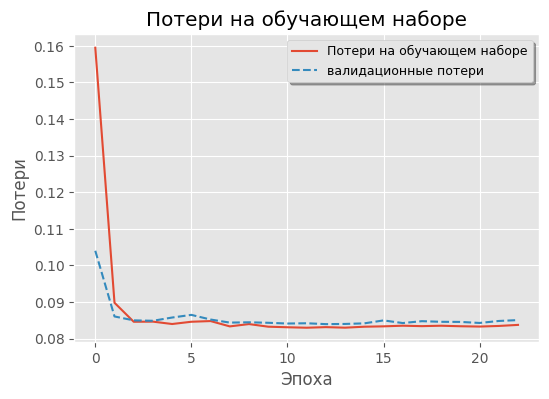

In [ ]:
plt.plot(history.history['loss'], label="Потери на обучающем наборе")
plt.plot(history.history['val_loss'], label="валидационные потери", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Потери на обучающем наборе")
plt.ylabel("Потери")
plt.xlabel("Эпоха")
plt.show()

### 📉 Оценка модели на различных данных

После обучения автоэнкодера была проведена оценка его работы на трёх типах данных:

- **Обучающий набор:** `MAE = 0.0829`  
- **Тестовый набор:** `MAE = 0.0843`  
- **Аномальные данные:** `MAE = 0.1192`

Метрика MAE (средняя абсолютная ошибка) показывает, насколько хорошо модель восстанавливает входные данные. Как видно, на **анормальных данных ошибка значительно выше**, чем на нормальных. Это означает, что **модель успешно отличает аномальные сигналы от нормальных**, что является ключевым показателем качества в задаче обнаружения аномалий.


In [ ]:
train_mae = model.evaluate(X_train, X_train, verbose=0)
test_mae = model.evaluate(X_test, X_test, verbose=0)
anomaly_mae = model.evaluate(anomaly_df, anomaly_df, verbose=0)

print("Ошибки на обучающем наборе данных: ", train_mae)
print("Ошибка на тестовом наборе данных: ", test_mae)
print("Ошибка на аномальном наборе данных:  ", anomaly_mae)

Ошибки на обучающем наборе данных:  0.08286198228597641
Ошибка на тестовом наборе данных:  0.08428030461072922
Ошибка на аномальном наборе данных:   0.11922167241573334


### 🔍 Функция предсказания и расчёт ошибки восстановления

Создана функция `predict`, которая:

- Принимает обученную модель и входные данные `X`;
- Получает восстановленные (предсказанные) данные через автоэнкодер;
- Вычисляет среднюю абсолютную ошибку (MAE) между входом и восстановлением.

Это позволяет определить, насколько хорошо модель справляется с восстановлением сигналов. Чем выше ошибка восстановления — тем больше вероятность, что перед нами **аномалия**.


In [ ]:
def predict(model, X):
    pred = model.predict(X, verbose=False)
    loss = mae(pred, X)
    return pred, loss


### 🎯 Определение порога для детекции аномалий

После обучения модели автоэнкодера были рассчитаны значения ошибки восстановления (MAE) на нормальных и аномальных данных.  
Для определения порога, отделяющего **нормальные** данные от **аномальных**, был выбран следующий подход:

**Порог = Среднее значение MAE на обучающих данных + Стандартное отклонение MAE на обучающих данных**

То есть:

**Порог = μ_train + σ_train**,  
где:  
- **μ_train** — среднее значение MAE на обучающих нормальных данных,  
- **σ_train** — стандартное отклонение MAE на этих же данных.

Это позволяет отсеивать случаи, в которых ошибка восстановления значительно превышает привычный для модели уровень.

На графике отображено распределение ошибок восстановления:
- для обучающей и тестовой выборки нормальных данных,
- для аномальных данных.

Через пунктирную линию показан установленный порог. Все примеры с ошибкой выше него считаются **аномалиями**.


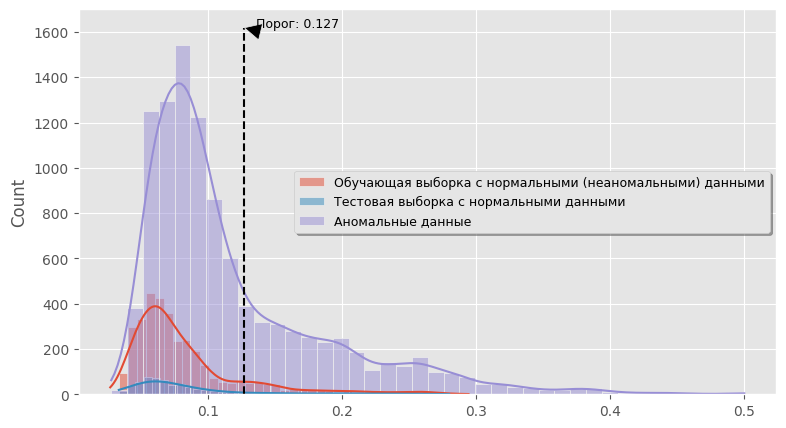

In [ ]:
_, train_loss = predict(model, X_train)
_, test_loss = predict(model, X_test)
_, anomaly_loss = predict(model, anomaly)
threshold = np.mean(train_loss) + np.std(train_loss) # Установка порога для различения нормальных данных от аномальных

bins = 40
plt.figure(figsize=(9, 5), dpi=100)
sns.histplot(np.clip(train_loss, 0, 0.5), bins=bins, kde=True, label="Обучающая выборка с нормальными (неаномальными) данными")
sns.histplot(np.clip(test_loss, 0, 0.5), bins=bins, kde=True, label="Тестовая выборка с нормальными данными")
sns.histplot(np.clip(anomaly_loss, 0, 0.5), bins=bins, kde=True, label="Аномальные данные")

ax = plt.gca()  # Get the current Axes
ylim = ax.get_ylim()
plt.vlines(threshold, 0, ylim[-1], color="k", ls="--")
plt.annotate(f"Порог: {threshold:.3f}", xy=(threshold, ylim[-1]), xytext=(threshold+0.009, ylim[-1]),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=9)
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.show()

Функция plot_examples позволяет:

Наглядно сравнить оригинальный и восстановленный сигнал,

Увидеть, насколько хорошо автоэнкодер справляется с восстановлением,

Оценить величину ошибки на графике.



In [ ]:
def plot_examples(model, data, ax, title):
    pred, loss = predict(model, data)
    ax.plot(data.flatten(), label="Актуальные")
    ax.plot(pred[0], label = "Предсказанные")
    ax.fill_between(range(1, 188), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True,
              facecolor="inherit", loc=1, fontsize=7)
#                bbox_to_anchor = (0, 0, 0.8, 0.25))

    ax.set_title(f"{title} (потери: {loss[0]:.3f})", fontsize=9.5)

Этот код отображает 10 графиков:

5 примеров нормальных данных (из обучающей выборки X_train);

5 примеров аномальных данных (из anomaly).

Каждая пара графиков показывает, как автоэнкодер восстановил входной сигнал, и позволяет визуально сравнить точность восстановления между нормальными и аномальными примерами.



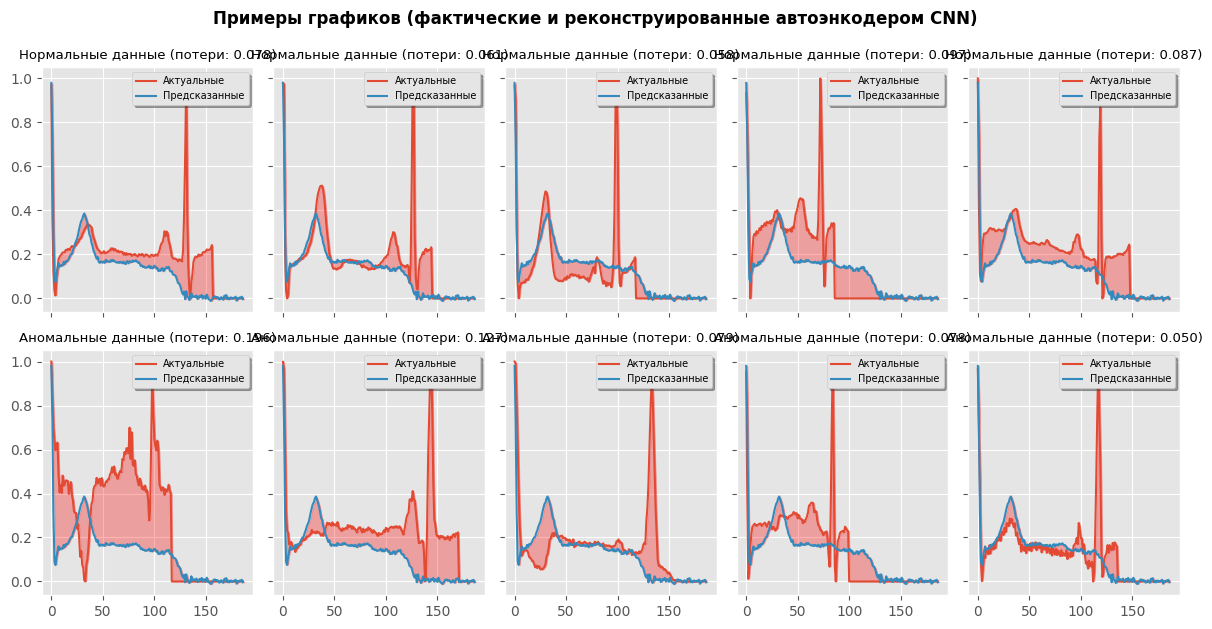

In [ ]:
fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(12, 6))
random_indexes = np.random.randint(0, len(X_train), size=5)

for i, idx in enumerate(random_indexes):
    data = X_train[[idx]]
    plot_examples(model, data, ax=axes[0, i], title="Нормальные данные")

for i, idx in enumerate(random_indexes):
    data = anomaly[[idx]]
    plot_examples(model, data, ax=axes[1, i], title="Аномальные данные")

plt.tight_layout()
fig.suptitle("Примеры графиков (фактические и реконструированные автоэнкодером CNN)", y=1.04, weight="bold")
fig.savefig("autoencoder.png")
plt.show()

In [ ]:
fig.savefig("autoencoder.png", dpi=500, transparent=False, facecolor="white")


# Оценка модели

Функция evaluate_model вычисляет точность модели автоэнкодера при классификации нормальных и аномальных данных.
Она определяет, насколько хорошо модель различает:

нормальные данные (loss ≤ threshold),

аномалии (loss > threshold).

In [ ]:
def evaluate_model(model, data):
    pred, loss = predict(model, data)
    if id(data) == id(anomaly):
        accuracy = np.sum(loss > threshold)/len(data)
    else:
        accuracy = np.sum(loss <= threshold)/len(data)
    return f"точность: {accuracy:.2%}"


In [ ]:
print("На обучающем наборе данных", evaluate_model(model, X_train))
print("На тестовом наборе данных", evaluate_model(model, X_test))
print("На аномальных данных", evaluate_model(model, anomaly))

На обучающем наборе данных точность: 87.00%
На тестовом наборе данных точность: 86.66%
На аномальных данных точность: 30.16%


Функция prepare_labels:

создаёт истинные метки (ytrue) для нормальных и аномальных данных;

генерирует предсказанные метки (ypred) на основе потерь от автоэнкодера и заданного порога threshold.

Она полезна для оценки качества модели с использованием метрик вроде точности, полноты, F1-score и построения confusion matrix.

In [ ]:
def prepare_labels(model, train, test, anomaly, threshold=threshold):
    ytrue = np.concatenate((np.ones(len(X_train)+len(X_test), dtype=int), np.zeros(len(anomaly), dtype=int)))
    _, train_loss = predict(model, train)
    _, test_loss = predict(model, test)
    _, anomaly_loss = predict(model, anomaly)
    train_pred = (train_loss <= threshold).numpy().astype(int)
    test_pred = (test_loss <= threshold).numpy().astype(int)
    anomaly_pred = (anomaly_loss < threshold).numpy().astype(int)
    ypred = np.concatenate((train_pred, test_pred, anomaly_pred))

    return ytrue, ypred

Функция plot_confusion_matrix:

Выводит на экран метрики качества: Accuracy, Precision, Recall, F1-score;

Строит и визуализирует матрицу ошибок, где показаны:

количество предсказаний каждого класса,

доли (в %) внутри каждого реального класса.



In [ ]:
def plot_confusion_matrix(model, train, test, anomaly, threshold=threshold):
    ytrue, ypred = prepare_labels(model, train, test, anomaly, threshold=threshold)
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred)
    recall = recall_score(ytrue, ypred)
    f1 = f1_score(ytrue, ypred)
    print(f"""\
        Accuracy: {accuracy:.2%}
        Precision: {precision:.2%}
        Recall: {recall:.2%}
        f1: {f1:.2%}\n
        """)

    cm = confusion_matrix(ytrue, ypred)
    cm_norm = confusion_matrix(ytrue, ypred, normalize="true")
    data = np.array([f"{count}\n({pct:.2%})" for count, pct in zip(cm.ravel(), cm_norm.ravel())]).reshape(cm.shape)
    labels = ["Аномальные", "Нормальные"]

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=data, fmt="", xticklabels=labels, yticklabels=labels)
    plt.ylabel("Фактические значения")
    plt.xlabel("Предсказанные значения")
    plt.title("Матрица ошибок", weight="bold")
    plt.tight_layout()

Этот код:

Использует обученную модель model (вероятно, CNN-автоэнкодер);

Оценивает её работу на обучающих, тестовых и аномальных данных;

Делит все данные на:

Нормальные (обучающие + тестовые),

Аномальные (отдельный датасет);

Сравнивает предсказания с фактическими метками;

Выводит:

Accuracy, Precision, Recall, F1;

Матрицу ошибок, с подписями:

Кол-во предсказаний;

Проценты по строкам.



        Accuracy: 45.95%
        Precision: 32.40%
        Recall: 86.95%
        f1: 47.21%

        


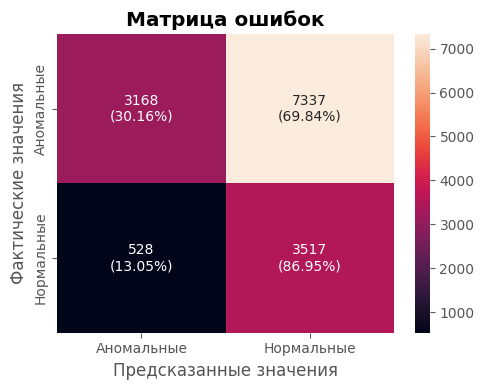

In [ ]:
plot_confusion_matrix(model, X_train, X_test, anomaly, threshold=threshold)

# Метрики оценки модели

### Следующие метрики оценки дают комплексную оценку эффективности модели:

Accuracy (45.95%): Accuracy измеряет долю правильных прогнозов среди всех прогнозов, сделанных моделью, что указывает на исключительно высокую общую правильность классификации.

Precision (32.40%): Precision — это процент истинно положительных прогнозов по отношению ко всем положительным прогнозам, сделанным моделью, что означает точность модели в правильном выявлении положительных случаев.

Recall (86.95%): Recall представляет собой способность модели точно идентифицировать положительные случаи среди всех фактических положительных случаев, демонстрируя сильную способность улавливать истинные положительные случаи..

F1 Score (47.21%): Оценка F1 — это составной показатель, который уравновешивает точность и полноту, обеспечивая общую оценку производительности модели.

In [ ]:
ytrue, ypred = prepare_labels(model, X_train, X_test, anomaly, threshold=threshold)
print(classification_report(ytrue, ypred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

  Нормальный       0.86      0.30      0.45     10505
  Аномальный       0.32      0.87      0.47      4045

    accuracy                           0.46     14550
   macro avg       0.59      0.59      0.46     14550
weighted avg       0.71      0.46      0.45     14550



prepare_labels(...):

Создаёт настоящие метки (ytrue):

1 — нормальные данные (из X_train и X_test);

0 — аномалии (из anomaly);

Вычисляет MAE-потери для каждого примера;

Присваивает предсказанные метки (ypred):

1, если ошибка меньше или равна порогу (threshold);

0 — иначе.

classification_report(...):

Строит подробный отчёт по метрикам:

Precision — точность (доля правильно предсказанных положительных);

Recall — полнота (доля найденных всех положительных);

F1-score — гармоническое среднее между Precision и Recall;

Support — сколько примеров класса было.

target_names=CLASS_NAMES:

Даёт названия классам вместо цифр (например: ["Аномалии", "Норма"]).

